In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import copy
import random
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import KFold
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as mdl
from IPython.display import clear_output
import time
import requests
import zipfile
import kagglehub
import torchvision
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

from sklearn.manifold import TSNE
from scipy.linalg import sqrtm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

type_of_run = "250x250_Crop_FullRun"
writer = SummaryWriter(f'runs/sick_leafs_{type_of_run}_{time.time()}')
start_time = time.time()
device

device(type='cuda', index=0)

## Hardware config

In [2]:
# Depending on the running config (can be used with XM-Dataset and VRAM > 12GB)
move_to_gpu = False
# Depending on the running config (can be used with XM-Dataset or Big-Dataset and RAM > 100GB)
move_to_ram_preprocess = True
# Depending on your cpu cores
num_workers = 16

## Dataset config

In [3]:
import json

# When the xm and big dataset are both selected, the data is merged together for training

# The original dataset
use_xm_dataset = True
# The new-plant-disease (very big) dataset
use_big_dataset = True
# The ai-lab dataset created by us. Only used for testing!
use_ai_lab_dataset = True

# undersample
use_undersampling = True

random_erase=0.1
scale_factor = 28
batch_size = 64
width = 250
height = 250

## Training config

In [4]:
# When having a lot of VRAM
use_efficientnet = True
patience = 10

## Check config

In [5]:

# Define the dataset config to save
dataset_config = {
    "use_xm_dataset": use_xm_dataset,
    "use_big_dataset": use_big_dataset,
    "use_ai_lab_dataset": use_ai_lab_dataset,
    "use_undersampling": use_undersampling,
    "batch_size": batch_size,
    "width": width,
    "height": height,
    "random_erase": random_erase,
    "scale_factor": scale_factor,
    "move_to_gpu": move_to_gpu,
    "move_to_ram_preprocess": move_to_ram_preprocess,
    "seed": seed,
}

config_path = "./data/dataset_config.json"
rerun_preprocessing = False

# Check if config file exists and compare
if os.path.exists(config_path):
    with open(config_path, "r") as f:
        old_config = json.load(f)
    if old_config != dataset_config:
        rerun_preprocessing = True
else:
    rerun_preprocessing = True



## Download datasets

In [6]:
import shutil

if rerun_preprocessing:
    print("Dataset configuration has changed. Deleting old data...")
    if os.path.exists('./data'):
        shutil.rmtree('./data')
        print("Deleted './data' directory.")
    
        # Save the current config
        os.makedirs(os.path.dirname(config_path), exist_ok=True)
        with open(config_path, "w") as f:
            json.dump(dataset_config, f, indent=2)
    else:
        print("'./data' directory does not exist.")

Dataset configuration has changed. Deleting old data...
Deleted './data' directory.


In [7]:
if use_ai_lab_dataset:
    share_url = "https://nextcloud.lr-projects.de/s/ZWGBcq67sPtordw"
    download_dir = "./data"
    zip_file = "ai-lab-dataset.zip"
    extract_dir = os.path.join(download_dir, "ai-lab-dataset")
    zip_path = os.path.join(download_dir, zip_file)

    if os.path.exists(zip_path):
        print("AI-Lab dataset already exsists. Skipping")
    else:
        os.makedirs(download_dir, exist_ok=True)
        zip_url = f"{share_url.rstrip('/')}/download"
        print(f"Downloading from: {zip_url}")

        response = requests.get(zip_url, stream=True)

        if response.status_code == 200:
            with open(zip_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Downloaded ZIP to: {zip_path}")
        else:
            raise Exception(f"Failed to download: HTTP {response.status_code}")

        # ---- Unzip the contents ----
        print(f"📦 Extracting ZIP to: {extract_dir}")
        os.makedirs(extract_dir, exist_ok=True)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

Downloaded ZIP to: ./data\ai-lab-dataset.zip
📦 Extracting ZIP to: ./data\ai-lab-dataset


In [8]:
# Download the datasets from kaggle

if use_big_dataset:
    path_set_1 = kagglehub.dataset_download('vipoooool/new-plant-diseases-dataset')
    path_set_1 = os.path.join(path_set_1, 'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)')
    print (f"Path set 1: '{path_set_1}'")
if use_xm_dataset:
    path_set_2 = kagglehub.dataset_download('amandam1/healthy-vs-diseased-leaf-image-dataset')
    print (f"Path set 2: {path_set_2}")

Path set 1: 'C:\Users\Fabian\.cache\kagglehub\datasets\vipoooool\new-plant-diseases-dataset\versions\2\New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
Path set 2: C:\Users\Fabian\.cache\kagglehub\datasets\amandam1\healthy-vs-diseased-leaf-image-dataset\versions\1


## Preprocess Datasets

In [9]:
transform_postprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_preprocess = transforms.Compose([
    transforms.Resize((width, height)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

transform_complete = transforms.Compose([
    transforms.Resize((width, height)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir=".", transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)
        label = self.labels_df.iloc[idx, 2] if 'Labels' in self.labels_df.columns else -1
        label = np.float32(label if label == 0 or label == 1 else 0)
        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
class NewCustomProcessedDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform):
        self.labels_df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_path = self.labels_df.iloc[idx]['Image']
        # If saved as PNG, just load and convert to tensor
        image = Image.open(img_path)
        image = self.transform(image)
        #image = transforms.ToTensor()(image)  # Only if needed, otherwise remove
        label = np.float32(self.labels_df.iloc[idx]['Labels'])
        return image, label

In [12]:
def generate_csv(root_dir, csv_path):
    data = []
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    index = 0
    num_label_0 = 0
    num_label_1 = 0

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.JPG', '.JPEG')):
                subfolder_name = os.path.basename(subdir)
                label = 0 if subfolder_name.endswith('healthy') else 1
                if label == 0:
                    num_label_0 += 1
                else:
                    num_label_1 += 1

                # Relative path from root (./train or ./valid)
                rel_path = os.path.relpath(os.path.join(subdir, file), '.')

                data.append([index, rel_path.replace("\\", "/"), label])
                index += 1
    print(f"Number of healthy images: {num_label_0}")
    print(f"Number of diseased images: {num_label_1}")
    df = pd.DataFrame(data, columns=['Index', 'Image', 'Labels'])
    df.to_csv(csv_path, index=False)
    print(f"Saved {len(df)} entries to {csv_path}")

In [13]:
def split_csv(csv_path, train_csv_path, valid_csv_path, split_ratio=0.8, overwrite=False):
    df = pd.read_csv(csv_path)
    train_df = df.sample(frac=split_ratio, random_state=seed)
    valid_df = df.drop(train_df.index)

    # If train_csv_path exists, append and update index
    if os.path.exists(train_csv_path) and not overwrite:
        existing_train = pd.read_csv(train_csv_path)
        train_df = pd.concat([existing_train, train_df], ignore_index=True)
        train_df['Index'] = range(len(train_df))
    else:
        os.makedirs(os.path.dirname(train_csv_path), exist_ok=True)
        train_df['Index'] = range(len(train_df))

    # If valid_csv_path exists, append and update index
    if os.path.exists(valid_csv_path) and not overwrite:
        existing_valid = pd.read_csv(valid_csv_path)
        valid_df = pd.concat([existing_valid, valid_df], ignore_index=True)
        valid_df['Index'] = range(len(valid_df))
    else:
        valid_df['Index'] = range(len(valid_df))
        os.makedirs(os.path.dirname(valid_csv_path), exist_ok=True)

    train_df.to_csv(train_csv_path, index=False)
    valid_df.to_csv(valid_csv_path, index=False)

    print(f"Saved {len(train_df)} training entries to {train_csv_path}")
    print(f"Saved {len(valid_df)} validation entries to {valid_csv_path}")


In [14]:
def evaluate_dataset(csv_path_1, csv_path_2, model):
    
    model.eval()
    dataset1 = CustomDataset(csv_file=csv_path_1, transform=transform_complete)
    dataset2 = CustomDataset(csv_file=csv_path_2, transform=transform_complete)

    loader1 = torch.utils.data.DataLoader(dataset1, batch_size=64, shuffle=False)
    loader2 = torch.utils.data.DataLoader(dataset2, batch_size=64, shuffle=False)

    def extract_embeddings(loader):
        embeddings = []
        with torch.no_grad():
            for images, _ in tqdm(loader, desc="Extracting embeddings"):
                images = images.to(device)
                feats = model(images)
                embeddings.append(feats.cpu())
        return torch.cat(embeddings, dim=0)

    embeddings1 = extract_embeddings(loader1)
    embeddings2 = extract_embeddings(loader2)
    min_len = min(len(embeddings1), len(embeddings2))
    embeddings1 = embeddings1[:min_len]
    embeddings2 = embeddings2[:min_len]

    def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
        # Calculate the mean and covariance difference
        diff = mu1 - mu2
        covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)

        # Numerical stability
        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)
        return fid

    # Convert to numpy
    embeddings1_np = embeddings1.numpy()
    embeddings2_np = embeddings2.numpy()

    # Compute mean and covariance
    mu1 = np.mean(embeddings1_np, axis=0)
    mu2 = np.mean(embeddings2_np, axis=0)
    sigma1 = np.cov(embeddings1_np, rowvar=False)
    sigma2 = np.cov(embeddings2_np, rowvar=False)

    # Calculate FID
    fid_score = calculate_fid(mu1, sigma1, mu2, sigma2)
    print("FID Score:", fid_score)

    all_embeddings = torch.cat([embeddings1, embeddings2], dim=0).numpy()
    labels = np.array([0]*len(embeddings1) + [1]*len(embeddings2))

    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(all_embeddings)

    plt.figure(figsize=(8,6))
    plt.scatter(embeddings_2d[labels==0,0], embeddings_2d[labels==0,1], alpha=0.5, label='Dataset 1')
    plt.scatter(embeddings_2d[labels==1,0], embeddings_2d[labels==1,1], alpha=0.5, label='Dataset 2')
    plt.legend()
    plt.title("t-SNE of Dataset Embeddings")
    plt.show()

In [15]:
# Create new csv files
if use_big_dataset:
    generate_csv(os.path.join(path_set_1, './train'), 'data/train.csv')
    generate_csv(os.path.join(path_set_1, './valid'), 'data/valid.csv')
    split_csv('data/train.csv', 'data/train.csv', 'data/evaluate/test_big.csv', overwrite=True)
if use_xm_dataset:
    generate_csv(path_set_2, 'data/dataset_xm.csv')
    split_csv('data/dataset_xm.csv', 'data/train_xm.csv', 'data/evaluate/test_xm.csv')
    split_csv('data/train_xm.csv', 'data/train.csv', 'data/valid.csv')
if use_ai_lab_dataset:
    generate_csv(extract_dir, 'data/evaluate/test_ai_lab.csv')

Number of healthy images: 22294
Number of diseased images: 48001
Saved 70295 entries to data/train.csv
Number of healthy images: 5572
Number of diseased images: 12000
Saved 17572 entries to data/valid.csv
Saved 56236 training entries to data/train.csv
Saved 14059 validation entries to data/evaluate/test_big.csv
Number of healthy images: 2129
Number of diseased images: 2107
Saved 4236 entries to data/dataset_xm.csv
Saved 3389 training entries to data/train_xm.csv
Saved 847 validation entries to data/evaluate/test_xm.csv
Saved 58947 training entries to data/train.csv
Saved 18250 validation entries to data/valid.csv
Number of healthy images: 4
Number of diseased images: 16
Saved 20 entries to data/evaluate/test_ai_lab.csv


In [16]:


def process_and_save_image(idx, row, transform, output_dir):
    img_path = os.path.join('.', row['Image'])
    try:
        image = Image.open(img_path).convert('RGB')
        processed_image = transform(image)  # Tensor C,H,W
        label = row['Labels'] if not pd.isna(row['Labels']) else -1
        label = np.float32(label if label == 0 or label == 1 else 0)

        # Convert tensor back to PIL Image for saving
        to_pil = transforms.ToPILImage()
        pil_img = to_pil(processed_image)

        # Save processed image with zero-padded index filename
        out_name = f"{idx:06d}.png"
        out_path = os.path.join(output_dir, out_name)
        pil_img.save(out_path)

        return out_path, label
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None, None
    
def preprocess_and_save_images(csv_file, output_dir, output_csv, transform, num_workers):
    if os.path.exists(output_csv):
        print(f"Output CSV '{output_csv}' already exists. Skipping preprocessing.")
        return

    os.makedirs(output_dir, exist_ok=True)
    df = pd.read_csv(csv_file)
    processed_entries = []

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [
            executor.submit(process_and_save_image, idx, row, transform, output_dir)
            for idx, row in df.iterrows()
        ]

        # Wrap the futures list with tqdm, then call result() inside the loop
        for f in tqdm(futures, desc="Preprocessing & saving images"):
            out_name, label = f.result()
            if out_name is not None:
                processed_entries.append([out_name, label])

    processed_df = pd.DataFrame(processed_entries, columns=['Image', 'Labels'])
    processed_df.to_csv(output_csv, index=False)
    print(f"Saved processed images to {output_dir} and CSV to {output_csv}")


In [17]:
class CustomProcessedDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file):
        self.labels_df = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_path = self.labels_df.iloc[idx]['Image']
        # If saved as PNG, just load and convert to tensor
        image = Image.open(img_path)
        image = image.convert('RGB')
        image = transforms.ToTensor()(image)  # Only if needed, otherwise remove
        label = np.float32(self.labels_df.iloc[idx]['Labels'])
        return image, label

In [18]:
# model = models.resnet50(pretrained=True)
# model.fc = torch.nn.Identity()
# model = model.to(device)
# evaluate_dataset('data/evaluate/valid.csv', 'data/dataset_2.csv', model)


In [19]:
train_csv = 'data/train.csv'
if use_undersampling:
    df = pd.read_csv(train_csv)
    min_count = df['Labels'].value_counts().min()

    # Sample min_count from each class
    df_minority = df[df['Labels'] == df['Labels'].value_counts().idxmin()]
    df_majority = df[df['Labels'] == df['Labels'].value_counts().idxmax()].sample(min_count, random_state=42)

    # Combine and shuffle
    df_balanced = pd.concat([df_minority, df_majority]).sample(frac=1, random_state=42).reset_index(drop=True)
    train_csv = 'data/train_undersampled.csv'
    df_balanced.to_csv(train_csv, index=False)


In [20]:
# Define the dataset and data loaders
preprocess_and_save_images(train_csv, 'data/processed_images/train', 'data/processed_train.csv', transform_preprocess, num_workers=num_workers)
preprocess_and_save_images('data/valid.csv', 'data/processed_images/valid', 'data/processed_valid.csv', transform_preprocess, num_workers=num_workers)

train_dataset = NewCustomProcessedDataset(csv_file='data/processed_train.csv',transform=transform_postprocess)
val_dataset = NewCustomProcessedDataset(csv_file='data/processed_valid.csv',transform=transform_postprocess)
if use_big_dataset:
    test_dataset_big = CustomDataset(csv_file='data/evaluate/test_big.csv', transform=transform_complete)
if use_xm_dataset:
    test_dataset_xm = CustomDataset(csv_file='data/evaluate/test_xm.csv', transform=transform_complete)
if use_ai_lab_dataset:
    test_dataset_ai_lab = CustomDataset(csv_file='data/evaluate/test_ai_lab.csv', transform=transform_complete)

KeyboardInterrupt: 

In [ ]:
def get_dataloader(sampler, dataset, to_ram, to_gpu, batch_size, num_workers=1):
    if to_ram:
        data = []
        labels = []
        for img, label in tqdm(dataset):
            data.append(img)
            labels.append(label)

        data = torch.stack(data)
        labels = torch.tensor(labels)

        if to_gpu:
            data = data.to(device)
            labels = labels.to(device)
        dataset = torch.utils.data.TensorDataset(data, labels)
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size, sampler=sampler, num_workers=num_workers)
    return loader, dataset

In [ ]:
def get_sampler(dataset, weighted=False):
    if weighted:
        # WeightedRandomSampler against class imbalance
        labels = dataset.labels_df['Labels'].values
        class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
        weights = 1. / class_sample_count
        samples_weights = np.array([weights[int(t)] for t in labels])
        samples_weights = torch.from_numpy(samples_weights).float()

        return torch.utils.data.WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)
    else:
        return torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=len(dataset))
 

# Data loaders
train_sampler = get_sampler(train_dataset)
validation_sampler = get_sampler(val_dataset)

In [ ]:
training_loader, train_dataset = get_dataloader(train_sampler, train_dataset, move_to_ram_preprocess, move_to_gpu, batch_size=batch_size, num_workers=num_workers)
validation_loader, val_dataset = get_dataloader(validation_sampler, val_dataset, move_to_ram_preprocess, move_to_gpu, batch_size=batch_size, num_workers=num_workers)

if use_xm_dataset:
    test_loader_xm = torch.utils.data.DataLoader(test_dataset_xm, batch_size=batch_size, shuffle=False)
    test_loader = test_loader_xm
if use_big_dataset:
    test_loader_big = torch.utils.data.DataLoader(test_dataset_big, batch_size=batch_size, shuffle=False)
    test_loader = test_dataset_big
if use_ai_lab_dataset:
    test_loader_ai_lab = torch.utils.data.DataLoader(test_dataset_ai_lab, batch_size=batch_size, shuffle=False)


100%|██████████| 18250/18250 [00:24<00:00, 744.09it/s]


# Data exploration

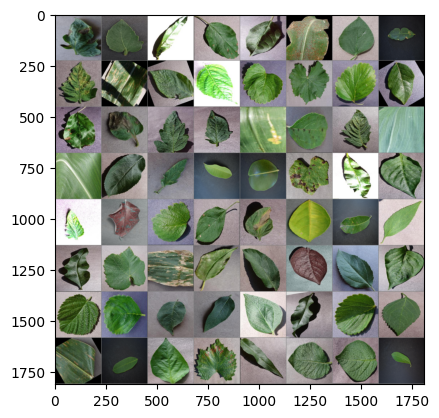

tensor([1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0.])
Number of samples in train_dataset: 38300
Number of samples in val_dataset_plant: 18250
Batch size: 64
Image shape (C, H, W): torch.Size([64, 3, 224, 224])
Label example: tensor([1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0.])


In [ ]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



# get some random training images
dataiter = iter(training_loader)
next(dataiter)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)

print(f"Number of samples in train_dataset: {len(train_dataset)}")
print(f"Number of samples in val_dataset_plant: {len(val_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Image shape (C, H, W): {images.shape}")
print(f"Label example: {labels}")

Train label distribution:
Label 0: 19150
Label 1: 19150

Validation label distribution:
Label 0: 5932
Label 1: 12318


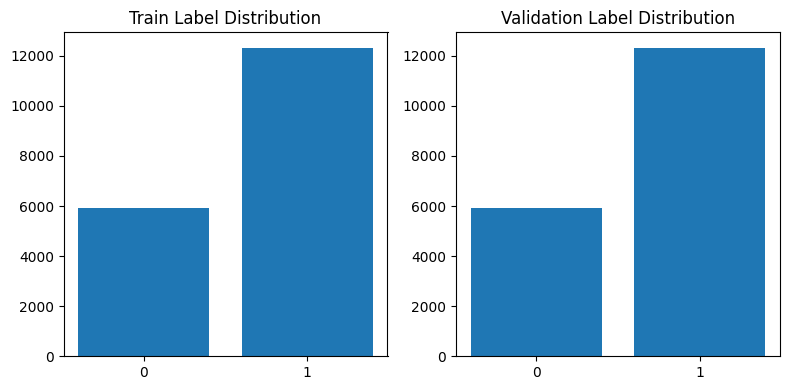

Sample image path: ../../../../.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Pepper,_bell___Bacterial_spot/a1e9e014-6dba-4e27-9990-bff1cb95c5d5___JR_B.Spot 9026_180deg.JPG
Image mode: RGB
Image size (W x H): (256, 256)
Image format: JPEG
Image file size: 16.49 KB
Imbalance ratio (min/max): 0.482

Data augmentation in use:
- Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
- RandomHorizontalFlip(p=0.5)
- RandomVerticalFlip(p=0.5)
- ToTensor()
- Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))


In [ ]:
# Datenexploration: Qualität, Bitrate, Verteilung der Labels, Dimension, etc.

def extract_labels(dataset):

    if isinstance(dataset, torch.utils.data.TensorDataset):
        return torch.tensor([label.item() if hasattr(label, 'item') else float(label) for _, label in dataset])
    elif hasattr(dataset, "labels_df"):
        return torch.tensor(dataset.labels_df["Labels"].values)
    else:
        return torch.tensor([dataset[i][1].item() if hasattr(dataset[i][1], 'item') else float(dataset[i][1]) for i in range(len(dataset))])

train_labels = extract_labels(train_dataset)
val_labels = extract_labels(val_dataset)

print("Train label distribution:")
unique, counts = train_labels.unique(return_counts=True)
for u, c in zip(unique.tolist(), counts.tolist()):
    print(f"Label {int(u)}: {c}")
print("\nValidation label distribution:")
unique, counts = val_labels.unique(return_counts=True)
for u, c in zip(unique.tolist(), counts.tolist()):
    print(f"Label {int(u)}: {c}")

# Plot label distribution
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.bar(unique.tolist(), counts.tolist())
plt.title('Train Label Distribution')
plt.xticks(unique.tolist())
plt.subplot(1, 2, 2)
val_unique, val_counts = val_labels.unique(return_counts=True)
plt.bar(val_unique.tolist(), val_counts.tolist())
plt.title('Validation Label Distribution')
plt.xticks(val_unique.tolist())
plt.tight_layout()
plt.show()

# Beispielbild: Qualität, Dimension, Bitrate
# Try to get the image path from the processed dataset if possible
if hasattr(train_dataset, "labels_df"):
    sample_img_path = train_dataset.labels_df.iloc[0]['Image']
else:
    # fallback: try to get from original CSV
    sample_img_path = df_balanced.iloc[0]['Image']
sample_img = Image.open(sample_img_path)
print(f"Sample image path: {sample_img_path}")
print(f"Image mode: {sample_img.mode}")
print(f"Image size (W x H): {sample_img.size}")
print(f"Image format: {sample_img.format}")

# Bitrate (Dateigröße in KB)
img_size_kb = os.path.getsize(sample_img_path) / 1024
print(f"Image file size: {img_size_kb:.2f} KB")

# Check for class imbalance
imbalance_ratio = counts.min() / counts.max()
print(f"Imbalance ratio (min/max): {imbalance_ratio:.3f}")
if imbalance_ratio < 0.5:
    print("Warning: The dataset is imbalanced!")

# Data augmentation check
print("\nData augmentation in use:")
for t in transform_complete.transforms:
    print("-", t)

## Models

In [ ]:
class Simple_CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(Simple_CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4, 4),

            nn.Conv2d(32, 32, kernel_size=15, padding=7),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4, 4),

        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(32 * int(width/(2**7)) * int(height/(2**7)), 4 * int(width/(2**7)) * int(height/(2**7))),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4 * int(width/(2**7)) * int(height/(2**7)), num_classes),
            #nn.Sigmoid(),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x #x.reshape(-1)
    
model = Simple_CNN()
model = model.to(device)

class FusedMBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=1, stride=1, squeeze=0, internal_kernel=3):
        super().__init__()
        expanded_channels = int(in_channels * expansion_factor)
        hidden_channels = expanded_channels

        # Expansion convolution (skip if expansion_factor == 1)
        #if expansion_factor != 1:
        #    self.expand = nn.Sequential(
        #        nn.Conv2d(in_channels, expanded_channels, kernel_size=1, bias=False),
        #        nn.BatchNorm2d(expanded_channels),
        #        nn.SiLU()
        #    )
        #else:
        #    self.expand = nn.Identity()
        self.expand = nn.Identity()

        # Depthwise convolution
        self.depthwise = nn.Sequential(
            #nn.Conv2d(expanded_channels, hidden_channels, kernel_size=internal_kernel, stride=stride, padding=int((internal_kernel-1)/2), groups=hidden_channels, bias=False),
            nn.Conv2d(in_channels, hidden_channels, kernel_size=internal_kernel, stride=stride, padding=int((internal_kernel-1)/2), bias=False),
            nn.BatchNorm2d(hidden_channels),
            nn.SiLU()
        )
        self.has_se = squeeze != 0
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels=hidden_channels, out_channels=squeeze, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(in_channels=squeeze, out_channels=hidden_channels, kernel_size=1),
            nn.Sigmoid(),
        )

        # Projection convolution
        self.project = nn.Sequential(
            nn.Conv2d(hidden_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.dropout = torchvision.ops.StochasticDepth(0.025, mode="row")
        # Use residual connection if possible
        self.use_residual = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        identity = x
        x = self.expand(x)
        x = self.depthwise(x)
        if self.has_se:
            x = x * self.se(x)
        x = self.project(x)

        if self.use_residual:
            x = self.dropout(x)
            x = x + identity

        return x

class SmallEfficientNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.SiLU()
        )

        self.blocks = nn.Sequential(
            FusedMBConvBlock(32, 32, expansion_factor=1, stride=1, squeeze=4, internal_kernel=3), #112
            nn.MaxPool2d(2),
            FusedMBConvBlock(32, 32, expansion_factor=2, stride=1, squeeze=4, internal_kernel=3), #56
            nn.MaxPool2d(2),
            FusedMBConvBlock(32, 32, expansion_factor=2, stride=1, squeeze=6, internal_kernel=5), #28
            nn.MaxPool2d(2),
            FusedMBConvBlock(32, 32, expansion_factor=2, stride=1, squeeze=8, internal_kernel=7), #14
            nn.MaxPool2d(2),
            FusedMBConvBlock(32, 32, expansion_factor=2, stride=1, squeeze=6, internal_kernel=7), #7
            nn.MaxPool2d(2),
            FusedMBConvBlock(32, 32, expansion_factor=2, stride=1, squeeze=4, internal_kernel=3),
        )

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        return x

# Verify the model
model = SmallEfficientNet()
print("Total parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# Example input (224x224 RGB image)
dummy_input = torch.randn(1, 3, 224, 224)
output = model(dummy_input)
print("Output shape:", output.shape)

Total parameters: 315554
Output shape: torch.Size([1, 2])


## Training

In [ ]:


def build_config(model, criterion=nn.BCELoss(), learn_rate=0.0001, optim_base=optim.AdamW, epochs=150, patience=10, early_stopping=True,choose_best_loss_model=True, verbose=True):
    dic = {}
    dic["model"] = model#copy.deepcopy(model)
    if criterion: dic["criterion"] = criterion
    if learn_rate: dic["learn_rate"] = learn_rate
    if optim_base: dic["optim_base"] = optim_base
    if epochs: dic["epochs"] = epochs
    if patience: dic["patience"] = patience
    if early_stopping: dic["early_stopping"] = early_stopping
    if choose_best_loss_model: dic["choose_best_loss_model"] = choose_best_loss_model
    if verbose: dic["verbose"] = verbose
    return dic 

def simple_train(model, train_loader, val_loader, criterion=nn.BCELoss(), learn_rate=0.0001, optim_base=optim.AdamW, epochs=150, patience=10, early_stopping=True, choose_best_loss_model=True, verbose=True):
    # Calculate the total number of parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    #print(f'Total number of parameters: {total_params}')
    intro_text = f"""Training {total_params} Parameters {model._get_name()} with 
          criterion: {criterion},
          optim_base: {optim_base},
          learn_rate: {learn_rate}, 
          epochs: {epochs}, 
          patience: {patience}, 
          early_stopping: {early_stopping}, 
          choose_best_loss_model: {choose_best_loss_model}"""
    print(intro_text)

    hash_int = hash((model._get_name(), criterion, learn_rate, optim_base, epochs, patience, early_stopping, choose_best_loss_model))
    path_name = f"{model._get_name()}, params: {total_params}, criterion: {criterion}, optim_base: {optim_base}, learn_rate: {learn_rate}, epochs: {epochs}, patience: {patience}, early_stopping: {early_stopping}, choose_best_loss_model: {choose_best_loss_model}/"
    
    print("--------")
    
    #writer.add_text(path_name+'train_loss', intro_text)

    optimizer = optim_base(model.parameters(), lr=learn_rate)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.75)

    # Move the model to GPU if available
    model.to(device)

    # Training loop with early stopping
    best_val_loss = float('inf')
    best_val_acc = 0
    patience_counter = 0
    outer_loop = tqdm(range(epochs), desc="Epochs")
    
    for epoch in outer_loop:
        #print(f'Epoch {epoch + 1}/{epochs}')
        model.train()
        running_loss = 0.0
        for idx, (images, labels) in enumerate(train_loader):
            if not move_to_gpu:
                images, labels = images.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            
            if (outputs.shape[1] == 2):
                labels = labels.long()
            

            outputs = outputs.squeeze(-1)

            loss = criterion(outputs, labels)

            if verbose:
                writer.add_scalar(path_name+'train_loss', loss.detach().item(), epoch*len(train_loader)+idx)
            running_loss += loss.detach().item()

            # Backward pass
            loss.backward()
            optimizer.step()

        #scheduler.step()
        #print(f'Training loss: {running_loss / len(train_loader)}')
        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                #print(outputs.shape)
                if (outputs.shape[1] == 2):
                    labels = labels.long()

                outputs = outputs.squeeze(-1)


                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Convert the outputs to predicted class labels
                if (outputs.shape[1] == 2):
                    predicted = outputs.argmax(dim=1).float() #torch.max(outputs, 1)
                else:
                    predicted = (outputs>0.5).float() #torch.max(outputs, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        if verbose:
            writer.add_scalar(path_name+'running_loss', running_loss / len(train_loader), epoch)
            writer.add_scalar(path_name+'val_loss', val_loss, epoch)
            writer.add_scalar(path_name+'val_acc', val_accuracy, epoch)

        tqdm.set_description_str(outer_loop,f"Epochs: [acc: ({val_accuracy:.4f}/{best_val_acc:.4f}), loss: ({val_loss:.4f}/{best_val_loss:.4f})]")
        #print(f'Validation loss: {val_loss / len(val_loader)}')
        #print(f'Validation accuracy: {val_accuracy:.4f}')

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = patience_counter - 1 if patience_counter > 0 else 0
            torch.save(model.state_dict(), 'best_acc_model.pth')
            #print(f'Best model saved with valid acc of {val_accuracy:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_val_model.pth')
            #print(f'Best model saved with valid loss of {val_loss / len(val_loader)}')
        else:
            patience_counter += 1
            if patience_counter >= patience and early_stopping:
                print("Early stopping triggered")
                break
    if (choose_best_loss_model):
        model.load_state_dict(torch.load('best_val_model.pth'))
        return model
    return model



In [ ]:
def eval(model, testing_loader):
    model.to(device)

    # Make predictions on the test dataset
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for images, label in testing_loader:
            images = images.to(device)
            outputs = model(images)
            if (outputs.shape[1] == 2):
                predicted = outputs.argmax(dim=1).float()
            else:
                predicted = (outputs>0.5).float()
            labels.extend(label.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

    # Create a DataFrame with IDs and predictions
    submission_df = pd.DataFrame({
        #'images': test_dataset.labels_df['Images'],
        'labels': predictions,
        'groundtruth': labels
    })

    submission_df_ones = submission_df[submission_df.groundtruth == 1]
    submission_df_zeros = submission_df[submission_df.groundtruth == 0]
    tp = (submission_df_ones.labels == submission_df_ones.groundtruth).sum()
    tn = (submission_df_zeros.labels == submission_df_zeros.groundtruth).sum()
    fn = (submission_df_ones.labels != submission_df_ones.groundtruth).sum()
    fp = (submission_df_zeros.labels != submission_df_zeros.groundtruth).sum()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    accuracy = (tp+tn)/(tp+tn+fn+fp)
    f1 = (2*precision*recall)/(precision+recall)
    return accuracy, precision, recall, f1, (tp, tn, fn, fp), submission_df

In [ ]:
def simple_hyper_train(configurations, verbose=True):
    model_list = []
    for config in configurations: 
        config["train_loader"] = training_loader
        config["val_loader"] = validation_loader
        config["verbose"] = verbose
        model = simple_train(**config)
        model_list.append(model)
    results = []
    for model in model_list:
        accuracy, precision, recall, f1, (tp, tn, fn, fp), submissions_df = eval(model, validation_loader)
        result = {
            "model": model,
            "accuracy": accuracy, 
            "precision": precision,
            "recall": recall, 
            "f1": f1, 
            "hidden": (tp, tn, fn, fp),
            "submissions_df": submissions_df,
        }
        results.append(result)
    return results

In [ ]:
def time_measure(model):
    # Get a batch from the validation_loader (which is a DataLoader, not subscriptable)
    dataiter = iter(validation_loader)
    image, label = next(dataiter)
    # If batch size > 1, take the first image
    if image.dim() == 4:
        image = image[0]
    image = image.unsqueeze(0)
    model.cpu()
    image = image.cpu()
    since = time.time()
    model(image)
    now = time.time()
    return now - since

In [ ]:
def shortend(configs, full=False):
    conf_out = []
    sub_df = configs[0]["submissions_df"]
    index_set = sub_df[sub_df.labels != sub_df.groundtruth].index
    index_set_outer = index_set
    for config in configs:
        sub_df = config["submissions_df"]
        d = {
            "name": config["model"]._get_name(),
            "parameters": sum(p.numel() for p in config["model"].parameters()),
            "accuracy": float(config["accuracy"]),
            "f1": float(config["f1"]),
            "time": time_measure(config["model"]),
            "wrong_idx": sub_df[sub_df.labels != sub_df.groundtruth].index,
            "solo_wrong_idx": sub_df[sub_df.labels != sub_df.groundtruth].index,
        }

        sub_df = config["submissions_df"]
        index_set = index_set.intersection(sub_df[sub_df.labels != sub_df.groundtruth].index)
        index_set_outer = index_set_outer.union(sub_df[sub_df.labels != sub_df.groundtruth].index)
        conf_out.append(d)

    for config_outer in conf_out:
        for config_inner in conf_out:
            if config_outer == config_inner:
                continue
            config_outer["solo_wrong_idx"] = config_outer["solo_wrong_idx"].difference(config_inner["wrong_idx"])

    if full:
        print(F"All: {index_set_outer}")
        print(F"Overlap: {index_set}")
    else:
        for config in conf_out:
            config["solo_wrong_idx"] = len(config["solo_wrong_idx"])
            config["wrong_idx"] = len(config["wrong_idx"])

        print(F"All: {len(index_set_outer)}")
        print(F"Overlap: {len(index_set)}")
    return conf_out

In [ ]:
def kfold_hyper_train(configs, verbose=False):
    k_folds = len(configs)
    kf = KFold(n_splits=k_folds, shuffle=True)

    model_list = []
    # Loop through each fold
    for fold, (train_idx, test_idx) in enumerate(kf.split(train_dataset)):
        print(f"Fold {fold + 1}")
        print("-------")

        # Define the data loaders for the current fold
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(train_idx),
        )
        val_loader = DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(test_idx),
        )
        config = configs[fold]
        config["train_loader"] = train_loader
        config["val_loader"] = val_loader
        config["verbose"] = verbose
        model = simple_train(**config)
        model_list.append((model, val_loader))
    results = []
    for model, loader in model_list:
        accuracy, precision, recall, f1, (tp, tn, fn, fp), submissions_df = eval(model, loader)
        result = {
            "model": model,
            "accuracy": accuracy, 
            "precision": precision,
            "recall": recall, 
            "f1": f1, 
            "hidden": (tp, tn, fn, fp),
            "submissions_df": submissions_df,
        }
        results.append(result)
    return results

In [ ]:
def choose_best_config(configs,clear=False):
    results = kfold_hyper_train(configs)
    results = [result["accuracy"] for result in results]
    def argmax(iterable):
        return max(enumerate(iterable), key=lambda x: x[1])[0]
    max_idx = argmax(results)
    if clear:
        clear_output()
    return configs[max_idx]

def build_configs(model: nn.Module,epochs=30):
    configs = [
        #build_config(copy.deepcopy(model), criterion=nn.CrossEntropyLoss(), learn_rate=0.1, epochs=75),
        build_config(copy.deepcopy(model), criterion=nn.CrossEntropyLoss(), learn_rate=0.01, patience=patience, epochs=epochs),
        build_config(copy.deepcopy(model), criterion=nn.CrossEntropyLoss(), learn_rate=0.001, patience=patience, epochs=epochs),
        build_config(copy.deepcopy(model), criterion=nn.CrossEntropyLoss(), learn_rate=0.0001, patience=patience, epochs=epochs),
        build_config(copy.deepcopy(model), criterion=nn.CrossEntropyLoss(), learn_rate=0.00001, patience=patience, epochs=epochs),
    ]
    return configs

def best_config(model: nn.Module,epochs=30):
    backup_model = copy.deepcopy(model)
    config = choose_best_config(build_configs(model),epochs)
    #config["original_model"] = config["model"]
    config["model"] = backup_model
    return config
configs = []

In [ ]:
if use_efficientnet:
    efficientnet_b0 = mdl.efficientnet_b0(weights="IMAGENET1K_V1")
    efficientnet_b0.classifier[1] = nn.Linear(efficientnet_b0.classifier[1].in_features, 2)
    configs.append(best_config(efficientnet_b0))

In [ ]:
squeezenet1_1 = mdl.squeezenet1_1(weights="IMAGENET1K_V1")
squeezenet1_1.classifier[1] = nn.Conv2d(512, 2, kernel_size=1,stride=1)
configs.append(best_config(squeezenet1_1))

In [ ]:
smallefficientnet = SmallEfficientNet()
configs.append(best_config(smallefficientnet))

In [ ]:
cnn = Simple_CNN()
configs.append(best_config(cnn))

In [ ]:
results = simple_hyper_train(configs)

Training 4010110 Parameters EfficientNet with 
          criterion: CrossEntropyLoss(),
          optim_base: <class 'torch.optim.adamw.AdamW'>,
          learn_rate: 0.0001, 
          epochs: 30, 
          patience: 10, 
          early_stopping: True, 
          choose_best_loss_model: True
--------


Epochs: [acc: (0.9973/0.9979), loss: (5.2003/2.5377)]:  43%|████▎     | 13/30 [15:52<20:45, 73.28s/it]


Early stopping triggered
Training 723522 Parameters SqueezeNet with 
          criterion: CrossEntropyLoss(),
          optim_base: <class 'torch.optim.adamw.AdamW'>,
          learn_rate: 0.0001, 
          epochs: 30, 
          patience: 10, 
          early_stopping: True, 
          choose_best_loss_model: True
--------


Epochs: [acc: (0.9912/0.9938), loss: (8.5393/4.6460)]:  57%|█████▋    | 17/30 [09:26<07:13, 33.32s/it] 


Early stopping triggered
Training 315554 Parameters SmallEfficientNet with 
          criterion: CrossEntropyLoss(),
          optim_base: <class 'torch.optim.adamw.AdamW'>,
          learn_rate: 0.001, 
          epochs: 30, 
          patience: 10, 
          early_stopping: True, 
          choose_best_loss_model: True
--------


Epochs: [acc: (0.9909/0.9930), loss: (10.6507/8.0125)]: 100%|██████████| 30/30 [16:37<00:00, 33.25s/it]


Training 275918 Parameters Simple_CNN with 
          criterion: CrossEntropyLoss(),
          optim_base: <class 'torch.optim.adamw.AdamW'>,
          learn_rate: 0.0001, 
          epochs: 30, 
          patience: 10, 
          early_stopping: True, 
          choose_best_loss_model: True
--------


Epochs: [acc: (0.9814/0.9849), loss: (94.6707/94.1714)]: 100%|██████████| 30/30 [18:01<00:00, 36.06s/it] 


In [ ]:
shortend(results)

All: 596
Overlap: 0


[{'name': 'EfficientNet',
  'parameters': 4010110,
  'accuracy': 0.9983013698630137,
  'f1': 0.9987356743749745,
  'time': 0.057505130767822266,
  'wrong_idx': 31,
  'solo_wrong_idx': 31},
 {'name': 'SqueezeNet',
  'parameters': 723522,
  'accuracy': 0.9926027397260274,
  'f1': 0.9944574454982141,
  'time': 0.0795145034790039,
  'wrong_idx': 135,
  'solo_wrong_idx': 132},
 {'name': 'SmallEfficientNet',
  'parameters': 315554,
  'accuracy': 0.9915616438356164,
  'f1': 0.9937525354969575,
  'time': 0.060506343841552734,
  'wrong_idx': 154,
  'solo_wrong_idx': 151},
 {'name': 'Simple_CNN',
  'parameters': 275918,
  'accuracy': 0.9846027397260274,
  'f1': 0.9885245232164005,
  'time': 0.04350852966308594,
  'wrong_idx': 281,
  'solo_wrong_idx': 277}]

In [ ]:
writer.add_text("results", str(shortend(results)))

All: 596
Overlap: 0


## Test datasets

In [ ]:
def test(results):
    eval_tables = []
    test_sets = []
    if use_xm_dataset:
        test_sets.append(("XM", test_loader_xm))
    if use_big_dataset:
        test_sets.append(("BIG", test_loader_big))
    if use_ai_lab_dataset:
        test_sets.append(("AI_LAB", test_loader_ai_lab))

    for test_name, loader in test_sets:
        rows = []
        for result in results:
            model = result["model"]
            accuracy, precision, recall, f1, (tp, tn, fn, fp), _ = eval(model, loader)
            rows.append({
                "Model": model._get_name(),
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1": f1,
                "TP": tp,
                "TN": tn,
                "FP": fp,
                "FN": fn
            })
        df = pd.DataFrame(rows)
        print(f"\nEvaluation on {test_name} test set:")
        display(df)
        eval_tables.append((test_name, df))
    return eval_tables
test(results)


Evaluation on XM test set:


,Model,Accuracy,Precision,Recall,F1,TP,TN,FP,FN
0,EfficientNet,0.962220,0.975638,0.951357,0.963345,841,789,21,43
1,SqueezeNet,0.953955,0.963218,0.947964,0.955530,838,778,32,46
2,SmallEfficientNet,0.937426,0.973236,0.904977,0.937866,800,788,22,84
3,Simple_CNN,0.893743,0.915094,0.877828,0.896074,776,738,72,108



Evaluation on BIG test set:


,Model,Accuracy,Precision,Recall,F1,TP,TN,FP,FN
0,EfficientNet,0.999004,0.999790,0.998744,0.999267,9539,4506,2,12
1,SqueezeNet,0.996230,0.997590,0.996859,0.997224,9521,4485,23,30
2,SmallEfficientNet,0.994594,0.998842,0.993194,0.996010,9486,4497,11,65
3,Simple_CNN,0.989473,0.995364,0.989111,0.992228,9447,4464,44,104



Evaluation on AI_LAB test set:


,Model,Accuracy,Precision,Recall,F1,TP,TN,FP,FN
0,EfficientNet,0.90,0.937500,0.9375,0.937500,15,3,1,1
1,SqueezeNet,0.75,0.823529,0.8750,0.848485,14,1,3,2
2,SmallEfficientNet,0.90,0.937500,0.9375,0.937500,15,3,1,1
3,Simple_CNN,0.85,0.882353,0.9375,0.909091,15,2,2,1


[('XM',
                 Model  Accuracy  Precision    Recall        F1   TP   TN  FP  \
  0       EfficientNet  0.962220   0.975638  0.951357  0.963345  841  789  21   
  1         SqueezeNet  0.953955   0.963218  0.947964  0.955530  838  778  32   
  2  SmallEfficientNet  0.937426   0.973236  0.904977  0.937866  800  788  22   
  3         Simple_CNN  0.893743   0.915094  0.877828  0.896074  776  738  72   
  
      FN  
  0   43  
  1   46  
  2   84  
  3  108  ),
 ('BIG',
                 Model  Accuracy  Precision    Recall        F1    TP    TN  FP  \
  0       EfficientNet  0.999004   0.999790  0.998744  0.999267  9539  4506   2   
  1         SqueezeNet  0.996230   0.997590  0.996859  0.997224  9521  4485  23   
  2  SmallEfficientNet  0.994594   0.998842  0.993194  0.996010  9486  4497  11   
  3         Simple_CNN  0.989473   0.995364  0.989111  0.992228  9447  4464  44   
  
      FN  
  0   12  
  1   30  
  2   65  
  3  104  ),
 ('AI_LAB',
                 Model  Accurac

In [ ]:
def display_misclassified_images_matrix(wrong, dataset, matrix_size=(5, 5)):
    num_rows, num_cols = matrix_size
    num_show = min(num_rows * num_cols, len(wrong))

    if num_show == 0:
        print("No misclassified images to display.")
        return

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    for i, (idx, pred, true) in enumerate(wrong[:num_show]):
        if i >= len(axes):
            break  # Stop if we run out of subplots

        # Retrieve the image path from the CSV stored in dataset.labels_df
        img_path = dataset.labels_df.iloc[idx]["Image"]
        img = Image.open(img_path)

        ax = axes[i]
        ax.imshow(img)
        ax.set_title(f"P: {pred}, T: {true}", fontsize=8)
        ax.axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    fig.set_size_inches(400/fig.dpi, 400/fig.dpi)
    plt.suptitle("Misclassified Images", y=1.02, fontsize=16)
    plt.show()

Test set XM: 57 misclassified images


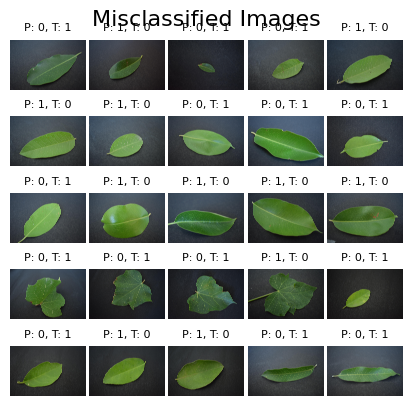

Test set BIG: 11 misclassified images


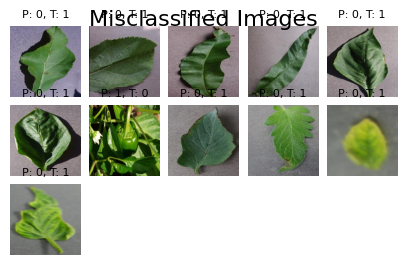

Test set AI_LAB: 2 misclassified images


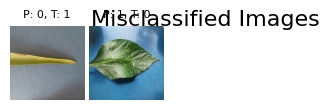

Test set XM: 91 misclassified images


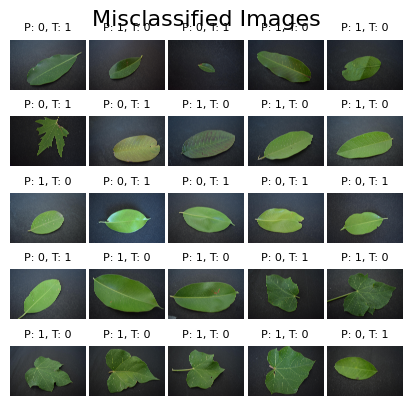

Test set BIG: 51 misclassified images


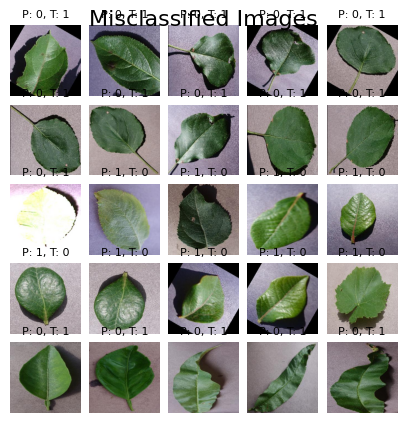

Test set AI_LAB: 5 misclassified images


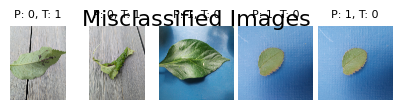

Test set XM: 91 misclassified images


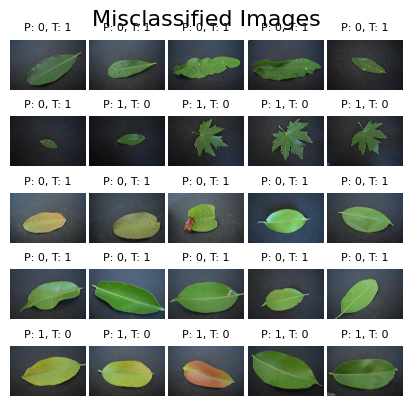

Test set BIG: 81 misclassified images


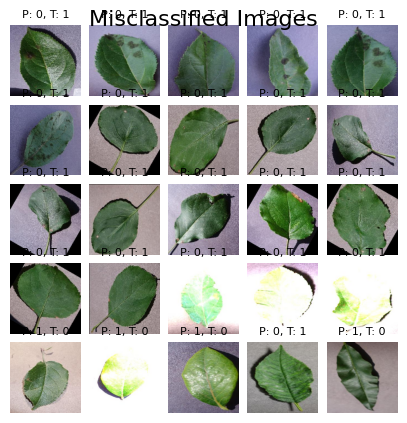

Test set AI_LAB: 4 misclassified images


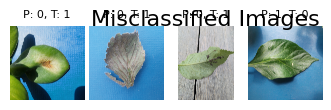

Test set XM: 175 misclassified images


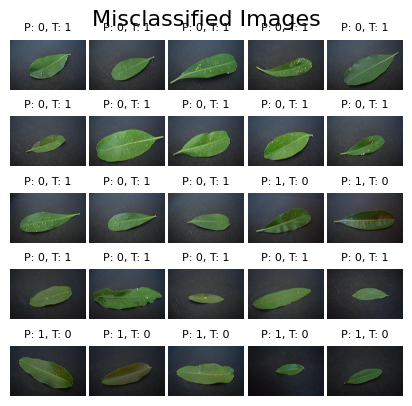

Test set BIG: 165 misclassified images


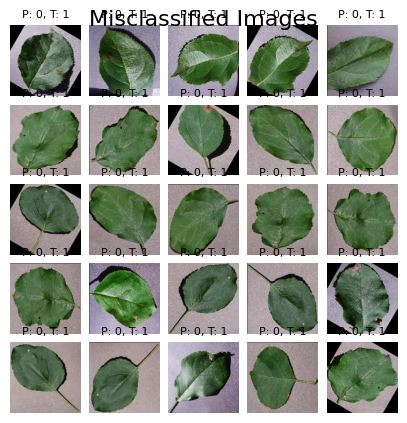

Test set AI_LAB: 3 misclassified images


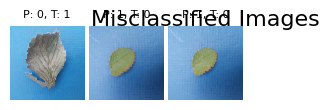

In [ ]:


# Collect available test datasets
test_sets = []
if 'test_dataset_xm' in globals():
    test_sets.append(("XM", test_dataset_xm))
if 'test_dataset_big' in globals():
    test_sets.append(("BIG", test_dataset_big))
if 'test_dataset_ai_lab' in globals():
    test_sets.append(("AI_LAB", test_dataset_ai_lab))
for result in results:
    best_model = result["model"]
    for ds_name, dataset in test_sets:
        wrong = []  # list of tuples: (dataset index, predicted, true label)
        for i in range(len(dataset)):
            image, label = dataset[i]
            input_tensor = image.unsqueeze(0).to(device)
            with torch.no_grad():
                # Ensure model and input are on the same device
                best_model = best_model.to(input_tensor.device)
                output = best_model(input_tensor)
                if output.shape[1] == 2:
                    pred = output.argmax(dim=1).item()
                else:
                    pred = (output > 0.5).float().item()
            if pred != int(label):
                wrong.append((i, pred, int(label)))
        
        print(f"Test set {ds_name}: {len(wrong)} misclassified images")
        
        # Display first 25 misclassified images
        display_misclassified_images_matrix(wrong, dataset, matrix_size=(5, 5))

In [ ]:
end_time = time.time()
taken = end_time - start_time
taken = taken/60
print(f"Notebook executed in {taken:4} minutes")

for result in results:
    model = result["model"]
    torch.save(model.state_dict(), f'{model._get_name()}_{type_of_run}_{start_time}.pth')

Notebook executed in 220.9922560453415 minutes


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

Reusing TensorBoard on port 6007 (pid 8604), started 5 days, 13:34:36 ago. (Use '!kill 8604' to kill it.)